In [0]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data



1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [0]:
# Importing necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [0]:
# Normalize the image and transform image for torchvision 

'''
Transforms are common image transformations. 
They can be chained together using Compose. 

torchvision.transforms.Compose(transforms)[SOURCE]: Composes several transforms together.
'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Load the CIFAR10 training datasets using torchvision
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# The PyTorch data loading utility is the torch.utils.data.DataLoader class. It represents a Python iterable over a dataset.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
# Load the CIFAR10 test datasets using torchvision
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# The PyTorch data loading utility is the torch.utils.data.DataLoader class. It represents a Python iterable over a dataset.
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
# Define the category labels for the images
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



 deer   dog   car horse


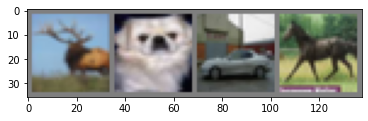

In [0]:
import matplotlib.pyplot as plt
import numpy as np


# Method to show the unnormalized image
def imshow(img):
    # Unnormalization of an image
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Returns some random image
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))
# Show out the labels for image
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network

Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [0]:
import torch.nn as nn
import torch.nn.functional as F

# Class definition for a convolution network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Defines convolution network layers
        
        # Applies a 2D convolution over an input signal composed of several input planes. nn.Conv2d(3, 6, 5) => in_channels=3, out_channels=6, kernel_size=5
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        # Applies a 2D max pooling over an input signal composed of several input planes. nn.MaxPool2d(2, 2) => kernel_size=2
        # torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.pool = nn.MaxPool2d(2, 2)

        # Applies a 2D convolution over an input signal composed of several input planes. nn.Conv2d(6, 16, 5) => in_channels=6, out_channels=16, kernel_size=5
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Applies a linear transformation to the incoming data: y = xA^T + b
        '''
        Parameters:
        in_features – size of each input sample
        out_features – size of each output sample
        bias – If set to False, the layer will not learn an additive bias. Default: True
        '''

        '''
        fc1
        in_features = 16 * 5 * 5 = 400
        out_features = 120
        bias = True
        '''
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        
        '''
        fc2
        in_features = 120
        out_features = 84
        bias = True
        '''
        self.fc2 = nn.Linear(120, 84)
        
        '''
        fc3
        in_features = 84
        out_features = 10
        bias = True
        '''
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Apply ReLU to conv1 output
        x = self.pool(F.relu(self.conv1(x)))
        # Apply ReLU to conv2 output
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        # Apply ReLU to fc1 output
        x = F.relu(self.fc1(x))
        # Apply ReLU to fc2 output
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [0]:
import torch.optim as optim
# Loss function used in the convolution neural network: Cross entropy loss
criterion = nn.CrossEntropyLoss()
# Optimizer for the convolution network: SGD
'''
Implements stochastic gradient descent (SGD)

Nesterov momentum is based on the formula from On the importance of initialization and momentum in deep learning.

torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)

  params (iterable) – iterable of parameters to optimize or dicts defining parameter groups => net.parameters()
  lr (python:float) – learning rate => 0.001
  momentum (python:float, optional) – momentum factor (default: 0) => 0.9

  weight_decay (python:float, optional) – weight decay (L2 penalty) (default: 0) => 0
  dampening (python:float, optional) – dampening for momentum (default: 0) => 0
  nesterov (bool, optional) – enables Nesterov momentum (default: False) => False
'''
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [0]:
# Iterate over the dataset multiple times
epochs = 2
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Gets the inputs
        inputs, labels = data

        optimizer.zero_grad()

        # Forward and backward propagations and optimization
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Calculates and shows the statistics for every 2000 batches.
        if i % 2000 == 1999:    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.195
[1,  4000] loss: 1.886
[1,  6000] loss: 1.676
[1,  8000] loss: 1.550
[1, 10000] loss: 1.499
[1, 12000] loss: 1.472
[2,  2000] loss: 1.382
[2,  4000] loss: 1.377
[2,  6000] loss: 1.347
[2,  8000] loss: 1.315
[2, 10000] loss: 1.309
[2, 12000] loss: 1.292
Finished Training


5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


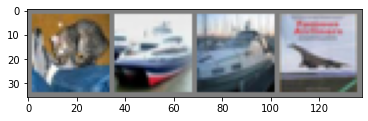

In [0]:
# Get few images
dataiter = iter(testloader)
images, labels = dataiter.next()

# Print images and their labels 
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [0]:
# Prints the labels guessed by our program to check our training.
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [0]:
correct = 0
total = 0
# Test with the whole dataset to see our accuracy percentage
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    # Add more details to our test to see which labels our program guessess with higher accuracy and which labels guesses are wrong.
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Prints labels and their accuracies.
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 76 %
Accuracy of   car : 79 %
Accuracy of  bird : 33 %
Accuracy of   cat : 35 %
Accuracy of  deer : 47 %
Accuracy of   dog : 45 %
Accuracy of  frog : 72 %
Accuracy of horse : 58 %
Accuracy of  ship : 45 %
Accuracy of truck : 55 %


Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor on to the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cpu


The rest of this section assumes that `device` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = inputs.to(device), labels.to(device)

Why dont I notice MASSIVE speedup compared to CPU? Because your network
is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

Training on multiple GPUs
-------------------------
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

Where do I go next?
-------------------

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_


